In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Generate synthetic square images
def create_ripped_square(image_size=64):
    img = np.ones((image_size, image_size))
    
    # Create a rip by splitting the image vertically
    rip_location = image_size // 2
    img[:, rip_location:] = 0
    
    # Optionally, add some noise or dislocation to the rip
    noise = np.random.rand(image_size, image_size) * 0.1
    img += noise
    
    complete_square = np.ones((image_size, image_size))  # Full square for the target

    return img, complete_square

class SquareDataset(Dataset):
    def __init__(self, n_samples=1000, image_size=64):
        self.n_samples = n_samples
        self.image_size = image_size

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        input_img, target_img = create_ripped_square(self.image_size)
        return torch.tensor(input_img, dtype=torch.float32).unsqueeze(0), torch.tensor(target_img, dtype=torch.float32).unsqueeze(0)

# Instantiate the dataset and dataloader
train_dataset = SquareDataset(n_samples=1000)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [15]:
with torch.no_grad():
    for input_img, target_img in train_loader:
        input_data = input_img.to('cuda')
        target_data = target_img.to('cuda')
        break

<Figure size 1600x1200 with 0 Axes>

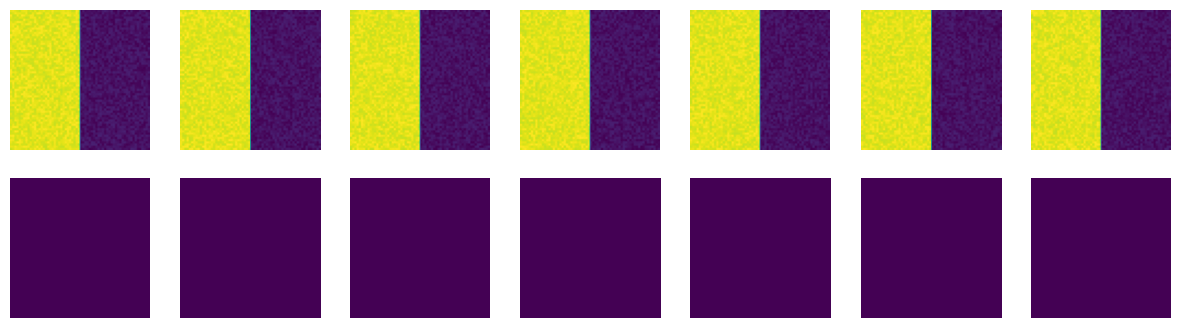

In [16]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(input_data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].imshow(target_data[i+7].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].axis('OFF')
plt.show()

In [17]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (batch_size, 16, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 32, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch_size, 64, 8, 8)
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 16, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 1, 64, 64)
            nn.Sigmoid()  # Output should be between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, loss function, and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()  # Mean Squared Error for pixel-wise reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
n_epochs = 20

for epoch in range(n_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Epoch [1/20], Loss: 0.1268
Epoch [2/20], Loss: 0.0009
Epoch [3/20], Loss: 0.0001
Epoch [4/20], Loss: 0.0000
Epoch [5/20], Loss: 0.0000
Epoch [6/20], Loss: 0.0000
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.0000
Epoch [9/20], Loss: 0.0000
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


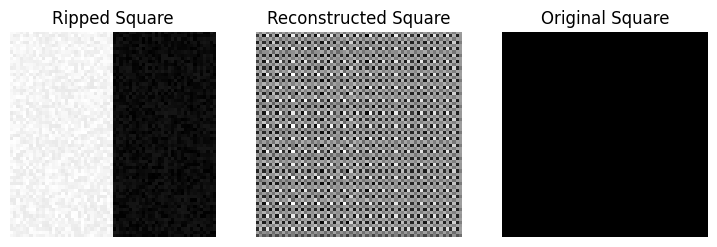

In [35]:
# Test the model on a sample
model.eval()
with torch.no_grad():
    for data in train_loader:
        inputs, targets = data
        outputs = model(inputs)
        break  # Test on the first batch only

# Visualize the results
def plot_images(input_img, output_img, target_img):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(input_img.squeeze(), cmap='gray')
    axes[0].set_title('Ripped Square')
    
    axes[1].imshow(output_img.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Square')
    
    axes[2].imshow(target_img.squeeze(), cmap='gray')
    axes[2].set_title('Original Square')

    for ax in axes:
        ax.axis('off')
    plt.show()

# Visualize a random sample from the batch
index = np.random.randint(0, len(inputs))
input_img = inputs[index]
output_img = outputs[index]
target_img = targets[index]

plot_images(input_img, output_img, target_img)
